# Word2vec with negative sampling

This notebook contains an implementation of word2vec with negative sampling. Word2vec implemented like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

The main idea of negative sampling is in the formula:

$$ L = \log\sigma(u^T_o \cdot u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j \cdot u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution.

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
1. [Word2vec Parameter Learning Explained](https://arxiv.org/pdf/1411.2738.pdf)

In [ ]:
import sys
from collections import Counter
import io
from pathlib import Path
import zipfile
import numpy as np
import requests
import math

NEG_WORD_TABLE_SIZE = 100000000

def load_corpus(save_dir="."):
    zip_file_url = "http://mattmahoney.net/dc/text8.zip"
    filename = "text8"
    filepath = Path(save_dir) / filename

    if not filepath.exists():
        print(f"Can't find {filepath}. Downloading from {zip_file_url}...")
        r = requests.get(zip_file_url)
        if r.ok:
            z = zipfile.ZipFile(io.BytesIO(r.content))
            print(f"Downloaded. Extracting...")
            z.extractall(save_dir)
            print(f"Extracted to directory {save_dir}")

    print(f"Opening {filepath}")
    with filepath.open('r') as data_f:
        document = data_f.read()

    return document.split()


def build_vocabulary(tokens, min_ocurrence_count=5):
    counter_items = Counter(tokens).items()
    vocabulary = set([
        word
        if count >= min_ocurrence_count
        else '<UNK>'
        for word, count in counter_items
    ])
    word2idx = {word: idx for idx, word in enumerate(vocabulary)}
    idx2word = {v: k for k, v in word2idx.items()}
    max_idx = max(list(word2idx.values()))
    word2idx['<PAD>'] = max_idx + 1
    idx2word[max_idx + 1] = '<PAD>'

    # create a table of negatives
    power = 0.75
    denominator = 0
    for word, count in counter_items:
        if count >= min_ocurrence_count:
            denominator += math.pow(count, power)

    neg_word_idx2prob = {}
    highest_prob = 0
    highest_prob_word_ind = 0
    for word, count in counter_items:
        if count < min_ocurrence_count:
            continue
        neg_word_idx2prob[word2idx[word]] = math.pow(count, power) / denominator
        if neg_word_idx2prob[word2idx[word]] > highest_prob:
            highest_prob = neg_word_idx2prob[word2idx[word]]
            highest_prob_word_ind = word2idx[word]

    # print(f"highest prob word {idx2word[highest_prob_word_ind]}, prob {highest_prob}, idx {highest_prob_word_ind}, count {highest_prob*NEG_WORD_TABLE_SIZE}")
    # print(f"cat proba {neg_word_idx2prob[word2idx['cat']]}, she proba {neg_word_idx2prob[word2idx['she']]}")

    neg_word_table = np.full(NEG_WORD_TABLE_SIZE, highest_prob_word_ind)
    neg_word_tbl_idx = 0
    for neg_word_idx, prob in neg_word_idx2prob.items():
        number_of_word = int(prob * NEG_WORD_TABLE_SIZE)
        neg_word_table[neg_word_tbl_idx:neg_word_tbl_idx+number_of_word] = neg_word_idx
        neg_word_tbl_idx += number_of_word

    return vocabulary, word2idx, idx2word, neg_word_table


class BatcherCBOW:
    def __init__(self, vocab, word2idx, idx2word, tokens, neg_word_table, window=2, neg_samples=5):
        self.vocab = vocab
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window = window
        self.tokens = tokens
        self.neg_word_table = neg_word_table
        self.neg_samples = neg_samples

    def get_neg_samples(self, word_idx):
        neg_sample_list = []

        for i in range(self.neg_samples):
            neg_word_tab_idx = np.random.randint(low=0, high=NEG_WORD_TABLE_SIZE, size=1)[0]
            neg_word_idx = self.neg_word_table[neg_word_tab_idx]
            if neg_word_idx == word_idx:
                while neg_word_idx == word_idx:
                    neg_word_tab_idx = np.random.randint(low=0, high=NEG_WORD_TABLE_SIZE, size=1)[0]
                    neg_word_idx = self.neg_word_table[neg_word_tab_idx]
            neg_sample_list.append(neg_word_idx)

        return np.asarray(neg_sample_list)

    def create_batch_of_seq_from_tokens(self, start_index, end_index):
        # for memory saving
        tokens = self.tokens
        X_data = np.zeros((end_index - start_index, self.window * 2), dtype=int)
        y_data = np.zeros((end_index - start_index,), dtype=int)
        neg_sample_data = np.zeros((end_index - start_index, self.neg_samples), dtype=int)

        res_idx = 0
        for i in range(start_index, end_index):
            word = tokens[i]
            if word not in self.vocab:
                word = '<UNK>'
            first_context_word_index = max(0, i - self.window)
            last_context_word_index = min(i + self.window + 1, len(tokens))
            context_words = []
            if i < self.window:
                context_words = [self.word2idx['<PAD>']] * (self.window - i)

            for j in range(first_context_word_index, last_context_word_index):
                if i != j:
                    if tokens[j] in self.vocab:
                        context_words.append(self.word2idx[tokens[j]])
                    else:
                        context_words.append(self.word2idx['<UNK>'])

            if i + self.window > len(tokens) - 1:
                context_words += [self.word2idx['<PAD>']] * (self.window - (len(tokens) - i) + 1)

            X_data[res_idx, :] = np.asarray(context_words)
            y_data[res_idx] = self.word2idx[word]
            neg_sample_data[res_idx, :] = self.get_neg_samples(self.word2idx[word])
            res_idx += 1

        return X_data, y_data, neg_sample_data

    def get_batch(self, batch_size=100):
        batches_per_epoch = int(len(self.tokens) // batch_size)
        counter = 0
        while 1:
            X_batch, y_batch, neg_sample_data = self.create_batch_of_seq_from_tokens(batch_size * counter, batch_size * (counter + 1))
            counter += 1
            yield X_batch, y_batch, neg_sample_data
            # restart counter to yeild data in the next epoch as well
            if counter >= batches_per_epoch:
                counter = 0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 300


class CBOW(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.v_embeddings = nn.Embedding(self.vocab_size, self.embedding_dim, sparse = True).cuda()
        self.u_embeddings = nn.Embedding(self.vocab_size, self.embedding_dim, sparse = True).cuda()

        initrange = 0.5 / self.embedding_dim
        self.v_embeddings.weight.data.uniform_(-initrange, initrange)
        self.u_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, batch):
        X, y, ns = batch[0], batch[1], batch[2]
        v_emb = torch.mean(self.v_embeddings(batch[0]), dim = 1)
        u_emb = self.u_embeddings(batch[1])

        score = torch.sum(torch.mul(v_emb, u_emb), dim = 1) # inner product
        log_target = F.logsigmoid(score)
        #negative
        neg_emb_u = self.u_embeddings(batch[2])
        neg_score = torch.bmm(neg_emb_u, v_emb.unsqueeze(2)).squeeze()
        neg_score = torch.sum(neg_score, dim=1)
        neg_score = F.logsigmoid(-1 * neg_score)
        loss = -1 * (log_target.sum() + neg_score.sum())
        return loss

    def get_word_emdedding(self, word, word2idx):
        index = word2idx[word]
        index = torch.tensor(index, dtype=torch.long).cuda()#.unsqueeze(0)
        emb = self.v_embeddings(index).view(1,-1).detach().cpu()
        return emb

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def plot_embeddings(M, word2Ind, words):
    M_reduced = TSNE(n_components=2).fit_transform(M)
    for word_ind, word in enumerate(words):
        x = M_reduced[word_ind,0]
        y = M_reduced[word_ind,1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=11)
    plt.show()  

time for 1000 batches: 43.974904655000046 sec
--------------------------------------------------------------------------------
Epoch: 0.54/199
Batch: 30000/56684 Batch Size: 300
Loss: 126.34867095947266
--------------------------------------------------------------------------------
Show the most similar words for the test list
word: she, similar words: ['he', 'they', 'him', 'you', 'it']
word: is, similar words: ['was', 'becomes', 'exists', 'does', 'be']
word: good, similar words: ['you', 'your', 'same', 'what', 'my']
word: book, similar words: ['article', 'books', 'novel', 'version', 'son']
word: dog, similar words: ['dog', 'wife', 'river', 'daughter', 'saint']
word: woman, similar words: ['person', 'woman', 'man', 'wife', 'mother']
word: waiter, similar words: ['total', 'million', 'few', 'prize', 'nobel']
word: tree, similar words: ['name', 'river', 'size', 'end', 'temperature']
word: go, similar words: ['come', 'you', 'went', 'try', 'refer']
word: take, similar words: ['refer', 'fin

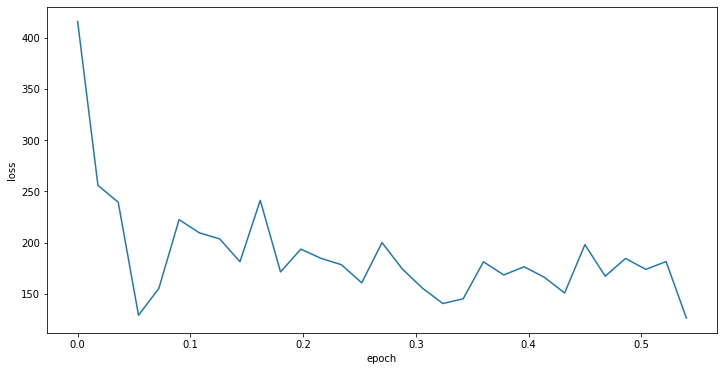

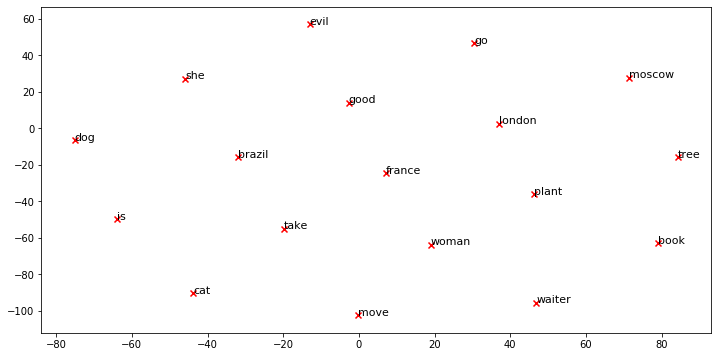

--------------------------------------------------------------------------------


In [ ]:
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [12, 6]
import timeit
import shutil

MODEL_PATH = "model.pt"
PATH_TO_COPY = "/content/model_copy.pt"
PATH_TO_COPY_BEST = "/content/best_model.pt"

MAX_EPOCH = 200
WINDOW = 2
BATCH_SIZE = 300
REPORT_NUM_BATCH = 1000

tokens = load_corpus()
vocabulary, word2idx, idx2word, neg_word_table = build_vocabulary(tokens)
cbow_batcher = BatcherCBOW(vocabulary, word2idx, idx2word, tokens, neg_word_table, window=WINDOW, neg_samples=5)
batches_per_epoch = int(len(tokens) // BATCH_SIZE)
report_epoch_perc_step = round(REPORT_NUM_BATCH/batches_per_epoch, 3)

batch_counter = 0
report_epoch_perc = 0
epoch_counter = 0
best_loss = 100
vocab_size = len(idx2word)

print(f'{batches_per_epoch} batches per epoch.')
print(f'Vocab_size={vocab_size}.')

model = CBOW(vocab_size, EMDEDDING_DIM)
#loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
model.cuda()

words_for_test = ['she', 'is', 'good', 'book', 'dog', 'woman', 'waiter', 
                 'tree', 'go', 'take', 'cat', 'evil', 'plant', 'move',
                 'london', 'moscow', 'brazil', 'france']

steps_plot = []
losses_plot = []

start = timeit.default_timer()

for X_batch, y_batch, ns_batch in cbow_batcher.get_batch(BATCH_SIZE):
    X_batch = torch.from_numpy(X_batch).cuda()
    y_batch = torch.from_numpy(y_batch).cuda()
    ns_batch = torch.from_numpy(ns_batch).cuda()

    model.zero_grad()
    loss = model((X_batch, y_batch, ns_batch))
    loss.backward()
    optimizer.step()
    
    # Print some results
    if batch_counter % REPORT_NUM_BATCH == 0:
        def most_similar(word, top_k=5):
            index = word2idx[word]
            index = torch.tensor(index, dtype=torch.long).cuda().unsqueeze(0)
            emb = model.v_embeddings(index)
            sim = torch.mm(emb, model.v_embeddings.weight.transpose(0, 1))
            nearest = (-sim[0]).sort()[1][1: top_k + 1]
            top_list = []
            for k in range(top_k):
                close_word = idx2word[nearest[k].item()]
                top_list.append(close_word)
            return top_list

        steps_plot.append(report_epoch_perc)
        losses_plot.append(loss.item())
        
        clear_output()
        end = timeit.default_timer()
        print(f"time for {REPORT_NUM_BATCH} batches: {end - start} sec")
        start = timeit.default_timer()
        print(f"-"*80)
        print(f'Epoch: {round(report_epoch_perc, 2)}/{MAX_EPOCH-1}')
        print(f'Batch: {batch_counter}/{batches_per_epoch} Batch Size: {BATCH_SIZE}')
        print(f'Loss:', loss.item())
        print(f"-"*80)
        print(f"Show the most similar words for the test list")
        for test_word in words_for_test:
          #print(f"word: {test_word}, embedding: {model.get_word_emdedding(test_word, word2idx).detach().cpu().numpy()[0]}")
          print(f"word: {test_word}, similar words: {most_similar(test_word)}")
        print(f"-"*80)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.plot(steps_plot, losses_plot)
        plt.show()

        np_embeddings = np.zeros((len(words_for_test), EMDEDDING_DIM))
        for ind_word, test_word in enumerate(words_for_test):
          np_embeddings[ind_word,:] = model.get_word_emdedding(test_word, word2idx).detach().cpu().numpy()[0]
        plot_embeddings(np_embeddings, word2idx, words_for_test)
        
        print(f"-"*80)
        report_epoch_perc += report_epoch_perc_step
        torch.save(model.state_dict(), MODEL_PATH)
        
        shutil.copy(MODEL_PATH, PATH_TO_COPY)
        if loss.item() < best_loss:
          best_loss = loss.item()
          shutil.copy(MODEL_PATH, PATH_TO_COPY_BEST)



    batch_counter += 1
    if batch_counter >= batches_per_epoch:
        batch_counter = 0
        epoch_counter += 1
        report_epoch_perc = epoch_counter
        if epoch_counter > MAX_EPOCH:
          break